# Lennard Jones gas in NVT ensemble

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

In [2]:
# Parameter
# all in reduced units
N=100
T=1.5
rho=0.9
V=N/rho
L=V**(1/3)
print(rho,L,V)

0.9 4.807498567691361 111.11111111111111


In [4]:
#distance in periodic boundary conditions
def norm_pb(_x,_y):
    return(norm(_x-(_y+L*np.rint((_x-_y)/L))))
    
#Lennard Jones potential truncated 
rc=2.5
def u(i,j,r_c=rc):
    r=norm_pb(i,j)
    if r>r_c: 
        return 0.
    else:        
        return 4*((1/r)**(12)-(1/r)**6)

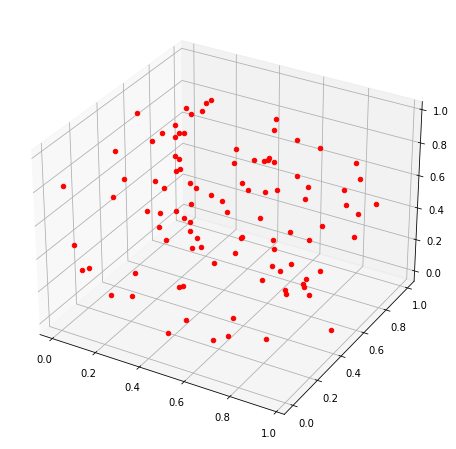

In [5]:
pos=[np.random.random(3) for i in range(N)]
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(projection='3d')
for x,y,z in pos:
    ax.scatter(x,y,z,'.',c='red')

In [6]:
#Verlet list

rv=2.7

def verl_list():
    posv=pos.copy()
    ver=[[]for i in range(N)]
    for i in range(N-1):
        for j in range(i+1,N):
            if norm_pb(pos[i],pos[j])<rv:
                ver[i].append(j)
                ver[j].append(i)
                
    return posv,ver

posv,ver=verl_list()

In [7]:
#Energy evaluation
## for single
def en_verl(i,k,ver):
    ev=0.
    for j in ver[i]:
        ev+=u(k,pos[j])/N
    return ev

#total energy
def e_tot_v():
    e_v=0
    for i in range(N):
        e_v+=en_verl(i,pos[i],ver)*0.5
    return e_v

#classical way
def en():
    e_p=0
    for i in range(N):
        for j in range(N):
            if i!=j:
                e_p+=u(pos[i],pos[j])/N*0.5
    return(e_p)

#show they are the same 
print(e_tot_v(),en())
e=e_tot_v()

2.5829778068614266e+17 2.582977806861362e+17


In [8]:
def mcmove_verl(ver,posv,step=0.1):
    #choose particle
    for i in range(N):
        p=np.random.randint(N)
        
        if norm_pb(pos[p],posv[p])>=(rv-rc)*0.5:
            posv,ver=verl_list()
        
        xi=(pos[p]+(0.5-np.random.random(3))*step+L)%L
        e0=en_verl(p,pos[p],ver)
        
        if norm_pb(xi,posv[p])>=(rv-rc)*0.5:
            posv,ver=verl_list()
            
        delta=en_verl(p,xi,ver)-e0
        
        if(np.logical_or(delta<=0,(delta>0 and np.exp(-delta/T)>np.random.random()))):
            pos[p]=xi
            
    return(ver.copy(),posv.copy())   

In [15]:
Te=10000

file='pos_'+str(N)+'_'+str(rho)+'.txt'
efile='energy_'+str(N)+'_'+str(rho)+'.txt'

os.remove(file)
os.remove(efile)
open(file,"w").close()
f=open(file,'a')

open(efile,"w").close()
g=open(efile,'a')
#em=e/Te
l=0

for t in range(Te):
    ver,posv=mcmove_verl(ver.copy(),posv.copy(),0.1)
    if t>l:
        np.savetxt(f,pos)
        f.write('\n')
        g.write(f'{t} {e_tot_v()}\n')
        l=l*1.1+1
    print("Loading " + str(int((t+1)/Te*100))+'%',end="\r")

f.close()
g.close()

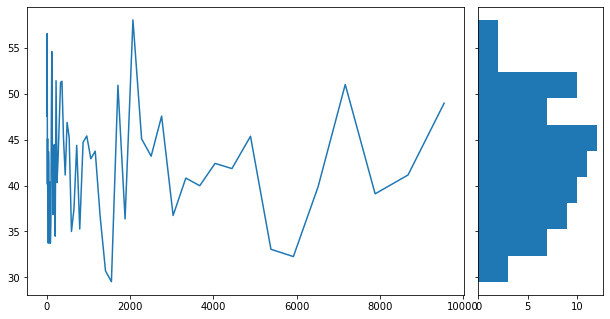

In [16]:
#plot temporal evolution of the energy and the histogram
te,E=np.loadtxt(efile,unpack=True)
fig=plt.figure(figsize=(10,5))
gs=fig.add_gridspec(1,2,width_ratios=(7, 2),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)
ax.plot(te,E)
ax_histy.hist(E,orientation='horizontal')
ax_histy.tick_params(axis="y", labelleft=False)

In [17]:
print(E)

[47.57837633 49.68809254 49.93425415 47.59385674 50.57657902 56.56032738
 50.65858402 52.55394648 50.70006338 45.95072649 40.14402353 45.13158289
 39.50142064 39.59014157 36.4188758  42.85997389 33.72124493 43.70134184
 42.42536466 35.66609848 33.80706051 39.27763258 40.37725023 33.68139847
 33.81795961 36.16913596 47.44892698 54.60344703 44.08855294 36.85335554
 44.2030902  44.4651441  34.48416364 51.43190282 40.33164702 43.02092849
 46.92822936 51.23674974 51.37009522 45.10071788 41.14708734 46.88822168
 45.25973296 34.99224222 37.42740856 44.38771525 35.26028048 44.71041991
 45.40451506 42.92337192 43.74561983 36.65267769 30.6920799  29.51504382
 50.93816759 36.35823288 58.06104702 45.08843122 43.19994028 47.57019841
 36.73897791 40.81121231 39.98165782 42.41583118 41.84959454 45.368089
 33.050566   32.25592394 39.85731503 51.01638205 39.09683431 41.15035308
 48.98381195]


## Radial Distribution function

In [33]:
dr=0.07
R=5
nh=np.int((R+dr)/dr)
rr=np.linspace(0,R,nh+1)
delg=L/(2*nh)

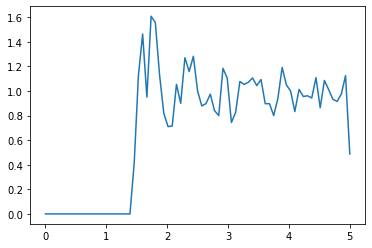

In [34]:
g=np.zeros(nh+1)
ng=0

def add_data(g,n_g=ng):
    for i in range(N-1):
        for j in range(i+1,N):
            r=norm_pb(pos[i],pos[j])
            if r<L/2:
                ig=np.rint(r/delg).astype(int)
                g[ig]+=2
    return(n_g+1)

def g_r(g,ng):
    G=g.copy()
    for i in range(len(G)):
        r=delg*(i+0.5)
        vb=((i+1)**3-i**3)*(delg**3)
        nid=4/3*np.pi*vb*rho
        G[i]=G[i]/(N*nid*ng)
    return G

ng=add_data(g,ng)
gg=g_r(g,ng)
plt.plot(rr,gg[:],'-')

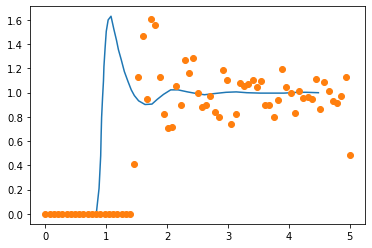

In [35]:
# comparison between the real and mine
(R,G)=np.loadtxt('radial_2.csv',delimiter=',',unpack=True)
plt.plot(R,G)
plt.plot(rr,gg[:],'o')

In [36]:
data=np.loadtxt(file)
data=data.reshape((len(te),N,3))

In [37]:
for i in range(0,data.shape[0]):
    pos=data[i,:,:]
    ng=add_data(g,ng)

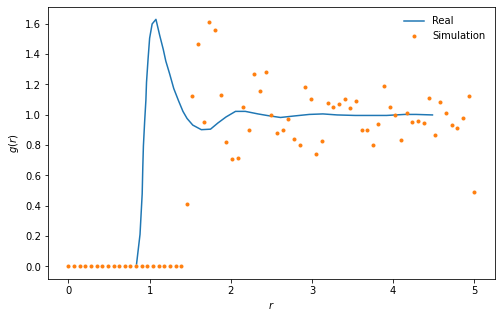

In [40]:
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot()
ax.plot(R,G,label='Real')
ax.plot(rr,gg[:],'.',label='Simulation')
ax.set_ylabel(r'$g(r)$')
ax.set_xlabel(r'$r$')
ax.legend(frameon=False)
#fig.savefig('g_T_'+str(T)+'_rho_'+str(rho)+'_N_'+str(N)+'.png')